## 0 Import all neccesary packages

In [1]:
#Within AS
# Caching Rate
import random
from multiprocessing import Queue
import sys
import sqlite3

import re
import optparse
import logging
import numpy
import logging
from visualize import visualizer as vis


import threading
from user import User

import sched, time
from topology_manager import TopologyManager, Paths, SocialPaths
import tempfile

import matplotlib.pyplot as plt
import networkx as nx

from zipf import gen_biased_zipf_requests, gen_zipf_requests, gen_bilateral_biased_zipf_requests
from Autonomous_System import AS

In [2]:
def zipf_generator(num_of_content = 100, num_of_request = 1000, offset = 0):
    alpha = 1
    req, pattern = gen_bilateral_biased_zipf_requests(alpha = 1,number_of_content = num_of_content, number_of_request = num_of_request, offset = offset)
    return pattern

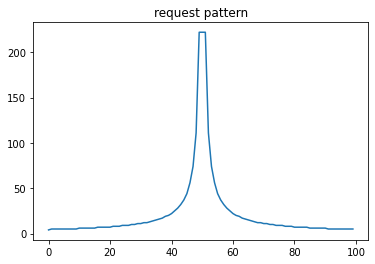

In [3]:
pattern = zipf_generator(num_of_content = 100, num_of_request = 1000, offset = 0)
plt.plot(pattern.keys(), pattern.values())
plt.title('request pattern')
plt.show()

## 1 Prepare instruaction parser

In [4]:
parser = optparse.OptionParser()
parser.add_option("-c", "--cache-size-per-node",
              dest="cache_size_per_node",
              help="space of cache allocated for every node in the topology",
              type=int,
              )
parser.add_option("-s", "--strategy",
              dest="caching_strategy",
              help="caching Strategy used for evaluating the trace"
              )
parser.add_option("-u", "--social-connections",
              dest="social_graph",
              help='social connections between users of the trace. Every trace includes users that executes actions.'
)
parser.add_option("-t", "--topology",
              dest="network_topology",
              help='network topology used for executing the trace.'
)
parser.add_option("-f", "--trace-file",
              dest="trace",
              default="",
              help='the trace to be executed',
)
parser.add_option("-p", "--replacement-policy",
              dest="replacement_policy",
              help='replacement policy used at every network node.',
)
parser.add_option("-m", "--mobility-enabled",
              dest="mobility_enabled",
              default=False,
              action="store_true",
              help="Enable mobility of users"
)
parser.add_option("-d", "--debug",
              dest="debug",
              default=False,
              action="store_true",
              help="Enable debugging options"
)
parser.add_option("-r", "--step-printing",
              dest="step_printing",
              default="",
              help = ""
)
parser.add_option("-z", "--zipf",
              dest="zipf",
              default=False,
              action="store_true",
              help = ""
)
parser.add_option("-e", "--method",
                 dest = "method",
                 default='random',
                 help = "random/geographical/onepublisher"
)
parser.add_option("-g", "--single-user",
                 dest = "single",
                 default=False,
                 action="store_true",
                 help = "if set, each topology node comes with only one user"
)
parser.add_option("-v", "--verbose",
                 dest = "verbose",
                 default=False,
                 action="store_true",
                 help = "if set, print cache storage info"
)

<Option at 0x1220a2a60: -v/--verbose>

In [5]:
def setup_logger(logger_name, log_file, level=logging.INFO, format_style = '%(asctime)-15s %(message)s',verbose=True):
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter(format_style)
    fileHandler = logging.FileHandler(log_file, mode='w')
    fileHandler.setFormatter(formatter)
    l.addHandler(fileHandler)
    streamHandler = logging.StreamHandler()
    streamHandler.setFormatter(formatter)
    l.addHandler(streamHandler)
    l.setLevel(level)
    return l

In [6]:
class Executor(object):
    def __init__(self, logger, social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename = '', mobility_enabled = False, step_printing = [], topology_file = None, zipf = False, method = 'random', single = False, verbose = False):
        self.lock = threading.Lock()
        self.condition = threading.Condition()
        #########################################
        #Initialize AS
        ##########################################
        nodes = list(topology.nodes())
        try:
            nodes.remove("server")
        except:
            pass
        self.AS = AS(nodes, True)
        logger.info("initialized Autonomous System")
        #########################################
        # Configuration
        #########################################
        self.round = 0
        ## Configure Cache
        self.num_of_request = 2000
        self.initialized_server = False
        self.num_of_content = 1000
        self.contents = ["/content/%s"%str(i) for i in range(self.num_of_content)]
        #########################################
        self.conf = {}
        self.conf['caching_strategy'] = caching_strategy
        self.conf['cache_policy'] = cache_policy
        self.conf['sequence_from_file'] = sequence_filename != ''
        self.conf['step_printing'] = step_printing
        self.method = method
        self.zipf_para = 1
        if self.conf['step_printing'] != None:
            self.steps = 0
        else:
            self.steps = None
        self.verbose = verbose
        #print("singledemo",single)
        #print("zipfdemo",zipf)

        ##########################################3
        # The topology manager handles user connection to CCN nodes.
        self.request_nodes = list(topology)
        self.topology = topology
        self.add_server_node()
        if single:
            self.social_nodes = self.topology
        ##############################################
        # Debugging
        #print(self.topology.nodes())
        logger.debug('Topology manager, connect users started')
        topology_coords = nx.spring_layout(topology)
        #topology_coords = {}
        #for node in topology.nodes():
        #    topology_coords[node] = (
        #            random.randint(0, 100),
        #            random.randint(0, 100)
        #    )
        self.topology_coords = topology_coords
        if single:
            self.social_graph = self.topology
            self.topology_nodes = TopologyManager(self.topology, self.topology, topology_coords, mobility_enabled, topology_file = topology_file)
        else:
            self.topology_nodes = TopologyManager(self.topology, self.social_graph, topology_coords, mobility_enabled, topology_file = topology_file)
        # 社交用户与节点之间关系为随机指定型
        # 后续的请求是用户发出的，所以，主要是要看如何将用户与请求 Pattern之间建立起关系
        self.topology_nodes.set_method(self.method)
        # 从网络中随机初始化网络节点
        # 从Social Network中随机初始化社交节点位置
        if not single:
            for user in social_graph.nodes():
                # update user node(user,pos)
                # initiate user position(coords_user)
                # 将用户映射到最近的拓扑节点上
                self.topology_nodes.update_user_position(user,(random.randint(0, 100), random.randint(0, 100)))
            self.topology_nodes.update_all_users_position()
        else:
            # 在单用户场景中，我们需要将用户初始化于相应的节点中
            for node in topology.nodes():
                    #TODO
                    self.topology_nodes.update_user_node(node,node)
        logger.debug('Topology manager, connect users finished')

        #
        self.users = {}
        for user in self.social_graph.nodes():
            self.users[user] = User(user)

        logger.debug('Start simulation')
        # debugging
        #print(self.topology_nodes.paths._path)

        self.sched = sched.scheduler(time.time, time.sleep)

        # Generate Sequence
        #print "generate sequence"
        if sequence_filename == '':
            self.generate_sequence()
        else:
            self.initialize_scheduler_from_file(sequence_filename)

        # Initialize Caches
        self.lock.acquire()
        # !!Cache Strategy Upper
        caching_strategy_upper = self.conf['caching_strategy'].upper()
        cm = getattr(getattr(__import__('cache_management.%s'%caching_strategy_upper), caching_strategy_upper), caching_strategy_upper)
        self.caches = cm(
                self.conf['cache_policy'],
                cache_size,
                self.social_graph,
                self.topology,
                self.topology_nodes,
                threshold = None
        )
        logger.debug('Loaded caching strategy')
        self.lock.release()
        self.initialize_catalog()
        ##//Initiate

    
    def initialize_scheduler(self, offset = 0):
        self.sched = sched.scheduler(time.time, time.sleep)
        ########################
        # TODO 接上Server
        if not self.initialized_server:
            self.initialize_Server()
            self.initialized_server = True
        ##########################
        #self.extract_sequence()
        #########################
        # Pending
        # 插入ZipF请求
        print("Start Simulating!")
        self.gen_zipf_sequence(num_of_content = self.num_of_content, num_of_request = self.num_of_request, r = self.round, offset = offset)
        ######################

        assert not self.sched.empty()


    ##############################################
    #TODO: currently not being used
    def initialize_scheduler_from_file(self, filename):
        self.seq_file = open(filename, 'r')
        self.seq_n = 0
    
    def extract_sequence(self):
        line = self.seq_file.readline()
        while line != '': #Empty line, we reach the end of the sequence
            # Retrieve fields in a line
            # Line format
            # |timestamp | event | User | mobility_x | mobility_y
            result = re.match ("(?P<timestamp>[0-9]*\.[0-9]+)\t(?P<activity>Retrieve|Publish|retrieve|publish|Retrievecontent|Publishcontent)\t(?P<user>[0-9]+)\t\((?P<dependent>.*)\)\t\((?P<mobility_x>[0-9\.]*), ?(?P<mobility_y>[0-9\.]*)\)", line)
            if result != None:
                #print step result
                if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                    # debugging
                    print(self.steps)
                    self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                    self.steps += 1
                # schedule an event (delay, priority, action, argument=())
                # delay, priority, action, argument=()
                # 使用的工具为：
                # 1 Producer2
                # 2 consumer
                # 3 consume_from_server
                pos = (float(result.group('mobility_x')), float(result.group('mobility_y')))
                if result.group('activity').lower() in ['publishcontent', 'publish']:
                    self.sched.enter(self.seq_n * 0.01, 0, self.producer2, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0] ))
                # 两类consumer
                elif result.group(2).lower() == 'retrieve':
                    self.sched.enter(self.seq_n * 0.01, 0, self.consumer, (int(result.group('user')), pos,))
                elif result.group(2).lower() == 'retrievecontent':
                    #print(self.seq_n * 0.01, 0,self.consume_from_server, (int(result.group('user'))), pos, "/content/%s"%result.group('dependent').split(',')[0])
                    self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_server, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0]))
            else:
                print("repr line: %s"%repr(line))
                exit(-1)
            self.seq_n+=1
            line=self.seq_file.readline()
    def initialize_catalog(self):
        self.f = tempfile.NamedTemporaryFile(delete=True, dir='/tmp/')
        self.conn = sqlite3.connect(self.f.name)
        self.c = self.conn.cursor()

        #c.execute('''DROP table catalog''')
        self.c.execute('''CREATE TABLE catalog
                     (content_name text, publisher int, date double, refer text, refered_level int, topic int)''')

    def generate_sequence(self, sequence = []):
        assert type(sequence) == list
        if sequence == []:
            self.sequence = [random.randint(0, len(self.social_graph.nodes())-1) \
                for i in range(0, len(self.social_graph)*40)]
            random.shuffle(self.sequence)
        else:
            self.sequence = sequence

    ###################################
    # 加入Server节点
    def add_server_node(self):
        node = random.choice(list(self.topology.nodes()))
        self.topology.add_node("server")
        self.topology.add_edge(node,"server")
        self.server = "server"
    ############################################
    # Initialize Server
    # 随机选取一个节点
    # 作为Server接上内容
    def initialize_Server(self):
        #################################
        # TODO
        # 找到中心节点
        # 加入一个Server节点
        # Pending
        for content in self.contents:
            self.sched.enter(self.seq_n * 0.01, 0, self.producer3, (self.server, content))
        #################################

    #################################
    # 生成符合Zipf分布的请求，并插入仿真器中
    # TODO:a Zipf sequence generator
    # Pending 01 将请求插入进编辑器中
    #def generate_Zipf_sequence(self,sequence = []):
    def zipf_generator(self,num_of_content, num_of_request, offset):
        alpha = self.zipf_para
        req, _ = gen_bilateral_biased_zipf_requests(alpha = alpha,number_of_content = num_of_content, number_of_request = num_of_request, offset = offset)
        return req
        
    def gen_zipf_sequence(self, num_of_content = 1000, num_of_request = 10000, r = 0, offset = 0):
        sequence = self.zipf_generator(num_of_content, 10*num_of_content, offset)
        if len(sequence)>=num_of_request:
            requests = sequence[:num_of_request]
        else:
            while(num_of_content):
                requests += sequence[:min(num_of_sequence,len(sequence))]
        #consume_from_server(user,position, contentname)
        # nodes must convert to list, or error appears
        for request in requests:
            ##############################################
            if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                    self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                    self.steps += 1
            ##############################################
            request_node = random.choice(self.request_nodes)
            while(request_node == "server"):
                request_node = random.choice(self.request_nodes)
            #consume_from_server(user,position, contentname)
            #目标是先从目标节点进行查找
            ## Scheduler 的用法
            # scheduler.enter(delay, priority, action, argument=(), kwargs={})
            # Pending# consume from server 应该被改成从目标中获取
            #print(self.social_graph.nodes())
            #pos = self.topology_coords[request_node]
            #self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_server, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0]))
            req = self.contents[request]
            # print(request_node, type(pos), type(req))
            # print(self.seq_n * 0.01, 0, self.consume_from_server, request_node, pos, req)
            self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_target, (request_node, req))
            self.seq_n+=1
        print("total seq num: ",self.seq_n)
     #################################
    
    def run(self, offset = 0):
        #print "the process begins"
        self.initialize_scheduler(offset = offset)
        self.sched.run()
        self.round += 1
        time.sleep(2)

        
    def __del__(self):
        self.conn.close()
    # 使用的是这一个！！
    # 将文件插入到数据库中
    def producer3(self, social_publisher, content, reference = '', topic = 0):
        #self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        #content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        #print("node",social_publisher, "publish",content)
        content_name = "%s"%content
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    # 使用的是这一个！！
    # 将文件插入到数据库中
    def producer2(self, social_publisher, position, content, reference = '', topic = 0):
        self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        #content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        #print("node",social_publisher, "publish",content)
        content_name = "%s"%content
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    ## Producer with position This is already abandoned~
    def producer(self, social_publisher, position, reference = '', topic = 0):
        logger.error("WARNING, this function is deprecated")
        exit(-1)
        self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
            topic = self.users[social_publisher].decide_next_topic()
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    #consume_from_server(user,position, contentname)
    def consume_from_server(self, social_issuer, position, content_name):
        #print "consume_from_server %s"%content_name
        # 首先将用户的位置进行更新为新的地点
        self.topology_nodes.update_user_position(social_issuer, position)
        # 然后
        content_retrieved = {}
        last = 0
        #寻找到存储这个内容的节点
        # Print Flag
        #print("Consume: ",content_name)
        for row in self.c.execute('SELECT * FROM catalog WHERE content_name == \"%s\" LIMIT 1'%( content_name )):
            # row的格式是：
            # content_name text, publisher int, date double, refer text, refered_level int, topic int
            last = row[0]
            reference = row[3]
            referer_level = row[4]
            topic = row[5]
            interest = last
            #从拓扑图中获取路径
            # 由于获取的时候
            # Print Flag
            
            path = self.topology_nodes.get_path(social_issuer, row[1])
            # Retrieve content and calculate statistics
            self.lock.acquire()
            self.caches._retrieve_from_caches(interest, path)
            self.lock.release()
        if self.verbose:
            print(self.printStats())

    def consumer(self, social_issuer, position):
        self.topology_nodes.update_user_position(social_issuer, position)
        content_retrieved = {}
        for social_neighbour in self.social_graph.neighbors(social_issuer):
            topology_neighbour = self.topology_nodes[social_neighbour]
            last = 0
            
            for row in self.c.execute('SELECT * FROM catalog WHERE publisher=%s and date BETWEEN %2f AND %2f ORDER BY date DESC LIMIT 1'%(social_neighbour, time.time()-0.2, time.time())):
                last = row[0]
                reference = row[3]
                referer_level = row[4]
                topic = row[5]
                #detecting original consumer
                while referer_level > 0:
                    for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" ORDER BY date DESC LIMIT 1'%reference):
                        last = row[0]
                        reference = row[3]
                        referer_level = row[4]
                        topic = row[5]
                #print row
                interest = last
                path = self.topology_nodes.get_path(social_issuer, social_neighbour)
                self.lock.acquire()
                self.caches._retrieve_from_caches(interest, path)
                self.lock.release()
            if self.verbose:
                print(self.printStats())
#########################################################
    # TODO: 先从目标节点中尝试获取缓存信息，然后再尝试从Server处获取缓存信息
    # Pending 02
    def consume_from_target(self, consumer, content_name) :
        # 目标节点
        # Pending： 需要向目标节点发出请求
        # target = hash_target(content_name)
        content_retrieved = False
        target = self.AS.get_node(content_name)
        #print("Consume: ",content_name,"Target is: ", target)
        path_to_target = self.topology_nodes.get_path(consumer, target)
        path_to_server = self.topology_nodes.get_path(consumer, self.server)
        target_to_server = self.topology_nodes.get_path(target,self.server)
        self.lock.acquire()
        self.caches.retrieve_content(content_name, target, path_to_target,self.server, target_to_server)
        #try:
            #  从目标节点中进行获取内容
            # retrieve_content(self, interest, target, path_to_target, server, path_to_server):
        #    self.caches.retrieve_content(content_name, target, path_to_target,self.server, target_to_server)
        #except:
        #    self.caches._retrieve_from_caches(content_name, path_to_server)
        self.lock.release()
        #if self.verbose:
        #    print(self.printStats())
#########################################################
    def get_expired_elements(self):
        # get last element of each social user
        #TODO: refactoring URGENT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        return 0
    def get_diversity(self):
        return self.stats.get_diversity(self.caches)
    def printStats(self):
        return self.caches.stats_summary()
    #############################################
    # print cache detail
    def printCaches(self):
        return self.caches.print_caches()
    ##############################################
    def printStepSummary(self, timestamp):
        print("=> {0} {1}".format(timestamp, self.caches.stats_summary()))
    def finishSimulation(self):
        del self.caches
        del self.topology_nodes 
        del self.sched
        self.c.close()
        self.lock.acquire()
        self.lock.release()
        self.condition.acquire()
        self.condition.notify()
        self.condition.release()

# Clear logger block

In [7]:
logger = logging.getLogger('logger')
while logger.handlers:
    logger.handlers.pop()
cache_info = logging.getLogger('cache_info')
while cache_info.handlers:
    cache_info.handlers.pop()
    cache_info = logging.getLogger('cache_info')

In [8]:
from importlib import reload
logging.shutdown()
reload(logging)

<module 'logging' from '/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/logging/__init__.py'>

## 4 😯Configure and run

In [9]:
logger = setup_logger('logger','example.log', level = logging.INFO, format_style = '%(message)s',verbose = False)
cache_info = setup_logger('cache_info','cache_info.log', level = logging.CRITICAL, format_style = '%(message)s',verbose = False)

In [10]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))

In [11]:
result = []

In [ ]:
#logger = setup_logger('logger', 'example.log', level=logging.INFO)
if options.debug:
    root = logging.getLogger()
    root.setLevel(logging.DEBUG)
    ch = logging.StreamHandler(sys.stdout)
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    root.addHandler(ch)
    root.info('Enable Debugging')
    # delivering original parameters
CACHE_SIZE = options.cache_size_per_node
CACHING_STRATEGY = options.caching_strategy
## Configure Cache
RUNS = 10
SOCIAL_GRAPH = options.social_graph
TOPOLOGY_GRAPH = options.network_topology
CACHE_STRUCTURE = options.replacement_policy
SEQUENCE_FILE = options.trace
ZIPF = options.zipf
SINGLE = options.single
VERBOSE = options.verbose
if SEQUENCE_FILE == "":
    logging.error("no trace file, using random generation of messages.")
    exit()
METHOD = options.method
if METHOD not in ['random','geographical','onepublisher']:
    root.error("WARNING, method is not listed, set to random")
    METHOD = 'random'
MOBILITY_ENABLED = options.mobility_enabled
if MOBILITY_ENABLED:
    root.debug("Mobility enabled")
else:
    root.debug("Mobility disabled")

try:
    STEP_PRINTING = [float(x) for x in options.step_printing.split(",") if x != '']
    root.debug("Step printing activated")
except IndexError:
    STEP_PRINTING = []
    root.debug("Step printing not activated")
CACHE_STRUCTURE = re.match('([a-zA-Z0-9_]*(\((?P<params>([0-9]*\.?[0-9]*,? ?)*)\))?)', CACHE_STRUCTURE)
assert CACHE_STRUCTURE != None
CACHE_STRUCTURE = CACHE_STRUCTURE.group(1)
# Import Social Graph
# Social Graph from folder graphs
G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
#plotGraph(G)
root.debug('Social Graph loaded')
#random.seed(10442)
# Import Topology Graph as a new class(peterson and pharse as topology class)
# social_graph is imported as a new class from folder graph, in this case, alibama
petersen = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
#plotGraph(petersen)
# social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename, mobility_enabled, step_printing, topology_file
executor = Executor(logger,G, petersen, CACHE_SIZE, CACHING_STRATEGY, CACHE_STRUCTURE, SEQUENCE_FILE, MOBILITY_ENABLED, STEP_PRINTING, topology_file=TOPOLOGY_GRAPH, zipf = ZIPF, method = METHOD, single = SINGLE, verbose = VERBOSE) 
offset = [0,2,4,6,8,10,12,14,16,18,20]
for i in range(0, RUNS):
    #print(executor.caches.print_caches())
    print("#####################################################################")
    print("Round# ", i+1)
    %time executor.run(offset = offset[i])
    executor.caches.update_predict_result()
    print(executor.printStats())
    result.append(executor.caches.stats._internal_hit)
    #print(executor.caches.print_caches())
    executor.caches.stats.reset()
    #print(executor.caches.pop)
executor.finishSimulation()
root.handlers.pop()
logger = logging.getLogger('logger')
while logger.handlers:
    logger.handlers.pop()
cache_info = logging.getLogger('cache_info')
while cache_info.handlers:
    cache_info.handlers.pop()

2021-05-25 14:51:50,922 - root - INFO - Enable Debugging
2021-05-25 14:51:50,923 - root - DEBUG - Mobility disabled
2021-05-25 14:51:50,923 - root - DEBUG - Step printing activated
2021-05-25 14:51:50,957 - root - DEBUG - Social Graph loaded


initialized Autonomous System


2021-05-25 14:51:50,965 - logger - INFO - initialized Autonomous System
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 222 ms, sys: 21.1 ms, total: 243 ms
Wall time: 22 s


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Round: 1 , internal_hit: 1207 , internal_miss: 793 , stretch : 1925 , cacheHit: 0.0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 793 eviction_operations: 793 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 198 ms, sys: 18.2 ms, total: 216 ms
Wall time: 42 s


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1444: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to co

Round: 2 , internal_hit: 1203 , internal_miss: 797 , stretch : 1881 , cacheHit: 0.0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 797 eviction_operations: 797 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  3
Start Simulating!
total seq num:  6000
CPU times: user 189 ms, sys: 17.7 ms, total: 207 ms
Wall time: 1min 2s


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Round: 3 , internal_hit: 1363 , internal_miss: 637 , stretch : 1485 , cacheHit: 0.0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 141 eviction_operations: 141 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  4
Start Simulating!
total seq num:  8000
CPU times: user 188 ms, sys: 18.4 ms, total: 206 ms
Wall time: 1min 22s


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Round: 4 , internal_hit: 1446 , internal_miss: 554 , stretch : 1299 , cacheHit: 0.0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 43 eviction_operations: 43 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  5
Start Simulating!
total seq num:  10000
CPU times: user 184 ms, sys: 18.5 ms, total: 202 ms
Wall time: 1min 42s


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Round: 5 , internal_hit: 1441 , internal_miss: 559 , stretch : 1300 , cacheHit: 0.0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 12 eviction_operations: 12 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  6
Start Simulating!
total seq num:  12000
CPU times: user 187 ms, sys: 19.4 ms, total: 207 ms
Wall time: 2min 2s


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Round: 6 , internal_hit: 1473 , internal_miss: 527 , stretch : 1239 , cacheHit: 0.0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 5 eviction_operations: 5 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  7
Start Simulating!
total seq num:  14000
CPU times: user 183 ms, sys: 18.9 ms, total: 202 ms
Wall time: 2min 22s


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Round: 7 , internal_hit: 1431 , internal_miss: 569 , stretch : 1330 , cacheHit: 0.0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 4 eviction_operations: 4 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  8
Start Simulating!
total seq num:  16000
CPU times: user 202 ms, sys: 21 ms, total: 223 ms
Wall time: 2min 42s


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Round: 8 , internal_hit: 1449 , internal_miss: 551 , stretch : 1297 , cacheHit: 0.0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 2 eviction_operations: 2 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  9
Start Simulating!
total seq num:  18000


In [ ]:
offset = [0,2,4,6,8,10,12,14,16,18,20]
contents = ["/content/%s"%str(i) for i in range(1000)]
patterns = {}
for i in range(len(offset)):
    req, pattern = gen_bilateral_biased_zipf_requests(alpha = 1,number_of_content = 1000, number_of_request = 10000, offset = offset[i])
    patterns[i] = pattern
data = []
for i in range(len(offset)):
    data.append(patterns[i][15])
plt.plot(data)


In [ ]:
data = {'/content/34': 2    0.085694
dtype: float64, '/content/384': 2    0.505546
dtype: float64, '/content/56': 2    0.170837
dtype: float64, '/content/205': 2    0.338307
dtype: float64, '/content/371': 2    0.505546
dtype: float64, '/content/360': 2    0.505546
dtype: float64, '/content/406': 2    0.338307
dtype: float64, '/content/813': 2    0.505546
dtype: float64, '/content/418': 2    0.505546
dtype: float64, '/content/441': 2    0.505546
dtype: float64, '/content/215': 2    0.505546
dtype: float64, '/content/741': 2    0.505546
dtype: float64, '/content/186': 2    0.505546
dtype: float64, '/content/740': 2    0.505546
dtype: float64, '/content/617': 2    0.505546
dtype: float64, '/content/790': 2    0.505546
dtype: float64, '/content/965': 2    0.505546
dtype: float64, '/content/210': 2    0.505546
dtype: float64}
sorted(data, key = lambda: d: d[1])

## 5 Visualization

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result)

In [ ]:
#TOPOLOGY_GRAPH = options.network_topology
#G = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
G = executor.topology
topo_vis = vis(G, executor.topology_coords)
node = random.choice(list(G.nodes()))
G.add_node("server", label = "server")
G.add_edge(node,"server")

In [ ]:
AS1 = AS(list(G.nodes()),True)
print(AS1.get_nodes())
AS1.get_node("coconut")

In [ ]:
        pos = executor.topology_coords
        Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
        fig = plt.figure(figsize=(10, 10))
        ax0 = fig.subplots()
        nx.draw_networkx_nodes(G, pos,  node_size = 80)
        nx.draw_networkx_edges(G,pos, alpha = 0.6)
        pos1 = {}
        for p in pos:  # raise text positions
            #pos[p] = [p[0]+0.05, p[1]+0.04]
            pos1[p] = pos[p][0]+0.005,pos[p][1]+0.003
        plt.title('label graph')
        nx.draw_networkx_labels(G, pos1,  font_size = 20)
        plt.show()
        #print(pos, pos1)

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
topo_vis.label_graph(font_size = 1, node_size = 210)

# 节点的介度

In [ ]:
print("Betweenness")
b = nx.betweenness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, b[v]))

print("Degree centrality")
d = nx.degree_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, d[v]))

print("Closeness centrality")
c = nx.closeness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, c[v]))

nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
print(sum(d.values()))

In [ ]:
print(44/21)

In [ ]:
SOCIAL_GRAPH = options.social_graph
G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
social_vis = vis(G)

In [ ]:
social_vis.degree_graph()

In [ ]:
social_vis.simple_graph(node_size = 10, alpha = 0.2, size = 12)

In [ ]:
print("Betweenness")
b = nx.betweenness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, b[v]))

print("Degree centrality")
d = nx.degree_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, d[v]))

print("Closeness centrality")
c = nx.closeness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, c[v]))

pos = nx.spring_layout(G)
nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
topo_vis.directed_graph()

In [ ]:
topo_vis.degree_graph()

In [ ]:
topo_vis.simple_graph()

In [ ]:
args = '-c 2 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True'
(options,args) = parser.parse_args(args.split(' '))

In [ ]:
TOPOLOGY_GRAPH = options.network_topology
G = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
topo_vis = vis(G)

In [ ]:
topo_vis.degree_graph()

In [ ]:
G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_nodes_from("Hello")
K3 = nx.Graph([(0, 1), (1, 2), (2, 0)])
G.add_nodes_from(K3)

In [ ]:
viser = vis(G)
viser.directed_graph()

In [ ]:
viser.degree_graph()